### **1. Libraries and Configurations**
----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### **2. Importing Dataset**
----

In [3]:
df = pd.read_csv('startup_failure_prediction.csv')
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,city,funding_rounds,Investors,Number_of_Investors,Acquirer,Acquirer_Category,Acquirer_Country,Acquirer_State,Acquirer_City,Acquired_Price,Acquired Currency,county,founded_at,Coordinates
0,H2O.ai,Software,33.600000,operating,USA,CA,Mountain View,4.0,Capital One:20000000|Nexus Venture Partners:33...,11.0,-,-,-,-,-,-,-,Santa Clara,2011,37.399364:-122.079517
1,One Inc.,Mobile,1.150050,operating,USA,CA,San Francisco,3.0,Camp One Ventures:150000|CRV:1000050|General C...,12.0,-,-,-,-,-,-,-,San Francisco,2011,37.727239:-123.032229
2,1000 Corks,Software,0.040000,operating,USA,OR,Lake Oswego,1.0,Start-Up Chile:40000,1.0,-,-,-,-,-,-,-,Clackamas,2008,45.412305:-122.699154
3,1000museums.com,Software,6.795451,operating,USA,MA,Lenox,9.0,Alliance of Angels:1289879.0|Converge Venture ...,7.0,-,-,-,-,-,-,-,Berkshire,2008,42.361228:-73.286788
4,Redox,Health,4.000000,operating,USA,WI,Madison,2.0,.406 Ventures:3530000|DreamIt Ventures:470000|...,6.0,-,-,-,-,-,-,-,Dane,2014,43.087806:-89.430121


### **3. Dataset Validation**
----

In [4]:
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.')

The dataset have 20 columns and 13732 rows.


In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
# Let's drop the non-usable columns

drop = [
    'name', 'investors', 'acquirer', 'acquirer_category', 'acquirer_country', 'acquirer_state', 
    'acquirer_city', 'acquired_price', 'acquired_currency', 'coordinates', 'county',
    'country_code', 'city' # << I put this columns here after categorical analysis
    ]

for col in drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [7]:
df.isnull().sum()

category_list          19
funding_total_usd      19
status                 19
state_code             19
funding_rounds         19
number_of_investors    19
founded_at             19
dtype: int64

In [8]:
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.\n')

The dataset have 7 columns and 13732 rows.



In [9]:
# Converting fouded_at to datetime and discovering the age of 

df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')

current_year = pd.Timestamp.now().year
df['startup_age'] = current_year - df['founded_at'].dt.year

df.drop(columns='founded_at', inplace=True)

In [10]:
categorical = []
numerical = []

for col in df.columns:
    if col == 'status' or col == 'founded_at':
        continue
    if df[col].dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)


Categorical columns: ['category_list', 'state_code']
Numerical columns: ['funding_total_usd', 'funding_rounds', 'number_of_investors', 'startup_age']


In [11]:
# Treating null-columns

for col in numerical:
    df[col] = df[col].fillna(df[col].mean())

In [12]:
df.dropna(inplace=True)
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.\n')

The dataset have 7 columns and 13713 rows.



### **4. Data Cleaning & Preprocessing**
----

#### 4.1 Target Variable

In [13]:
print(f'Target: status.')
print(f'- Number of Categories: {df['status'].nunique()}.')
print(f'- Categories: {df['status'].unique()}.')

Target: status.
- Number of Categories: 4.
- Categories: ['operating' 'acquired' 'closed' 'ipo'].


In [14]:
df['status_binary'] = df['status'].apply(lambda x: 1 if x == 'closed' else 0)
df.drop(columns='status', inplace=True)

print(df['status_binary'].value_counts(normalize=True).round(2))

status_binary
0    0.92
1    0.08
Name: proportion, dtype: float64


#### 4.2. Categorical Features

In [15]:
for col in categorical:
    df[col] = df[col].str.strip().str.lower().str.replace(' ', '_')

In [16]:
for col in categorical:
    print(f'Feature: {col}.')
    print(f'- Number of Categories: {df[col].nunique()}.')
    print(f'- Categories: {df[col].unique()}.')

Feature: category_list.
- Number of Categories: 26.
- Categories: ['software' 'mobile' 'health' 'finance' 'technology' 'manufacturing'
 'marketing' 'entertainment' 'education' 'hardware' 'services' 'games'
 'management' 'food' 'sports' 'travel' 'automation' 'business'
 'employment' 'communication' 'pharmaceuticals' 'style' 'entrepreneur'
 'industrial' 'gadget' 'construction'].
Feature: state_code.
- Number of Categories: 51.
- Categories: ['ca' 'or' 'ma' 'wi' 'ny' 'ri' 'ia' 'dc' 'nh' 'fl' 'md' 'ga' 'co' 'oh'
 'wa' 'nj' 'pa' 'sc' 'ct' 'va' 'tx' 'nc' 'in' 'il' 'mi' 'mn' 'tn' 'ut'
 'ar' 'hi' 'mo' 'ne' 'az' 'ks' 'me' 'ky' 'la' 'id' 'nd' 'vt' 'nm' 'ok'
 'ms' 'mt' 'ak' 'al' 'nv' 'de' 'sd' 'wy' 'wv'].


In [17]:
for col in categorical:
    print(f"\nColumn: {col}")
    freq_table = df[col].value_counts().reset_index()
    freq_table.columns = [col, 'count']
    freq_table['percent [%]'] = (freq_table['count'] / freq_table['count'].sum() * 100).round(2)
    print(freq_table)

# Here I discovered two important things:
# 1 - All startups are from the USA, so I will drop this column.
# 2 - There are many cities, which would create high cardinality, so I will drop this column as well.


Column: category_list
      category_list  count  percent [%]
0          software   4773        34.81
1        technology   1540        11.23
2          services   1088         7.93
3           finance   1073         7.82
4         marketing   1023         7.46
5            health    805         5.87
6     manufacturing    654         4.77
7         education    522         3.81
8     entertainment    497         3.62
9            mobile    477         3.48
10         hardware    373         2.72
11            games    242         1.76
12    communication    120         0.88
13       management    108         0.79
14           sports    108         0.79
15             food     81         0.59
16         business     65         0.47
17           travel     57         0.42
18       automation     37         0.27
19  pharmaceuticals     18         0.13
20     construction     18         0.13
21       employment     13         0.09
22            style     11         0.08
23       industri

In [18]:
for col in categorical:
    print(f"\nColumn: {col}")
    cross_tab = pd.crosstab(df[col], df['status_binary'], margins=True, normalize='index') * 100
    print(cross_tab.round(2))



Column: category_list
status_binary         0      1
category_list                 
automation        97.30   2.70
business          95.38   4.62
communication     94.17   5.83
construction      94.44   5.56
education         96.55   3.45
employment        84.62  15.38
entertainment     86.72  13.28
entrepreneur     100.00   0.00
finance           93.66   6.34
food              97.53   2.47
gadget           100.00   0.00
games             87.19  12.81
hardware          90.88   9.12
health            95.03   4.97
industrial       100.00   0.00
management        94.44   5.56
manufacturing     91.74   8.26
marketing         92.28   7.72
mobile            87.84  12.16
pharmaceuticals  100.00   0.00
services          92.65   7.35
software          92.10   7.90
sports            92.59   7.41
style            100.00   0.00
technology        94.35   5.65
travel            85.96  14.04
All               92.49   7.51

Column: state_code
status_binary       0      1
state_code                  


#### 4.3. Numerical Features

In [19]:
df[numerical].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T

# Here we have some outliers that where distorsing our dataset and informations.
# So I decided to apply log transformation to avoid the long tail distribution.

,count,mean,std,min,25%,50%,75%,90%,99%,max
funding_total_usd,13713.0,33.110598,324.551445,0.01,1.281,6.3,25.0,67.4,311.619106,30079.503
funding_rounds,13713.0,2.622767,1.926023,1.00,1.000,2.0,3.0,5.0,10.000000,19.000
number_of_investors,13713.0,4.253555,4.321169,1.00,1.000,3.0,6.0,9.0,20.880000,53.000
startup_age,13713.0,17.455323,7.230042,10.00,13.000,15.0,20.0,25.0,41.880000,123.000


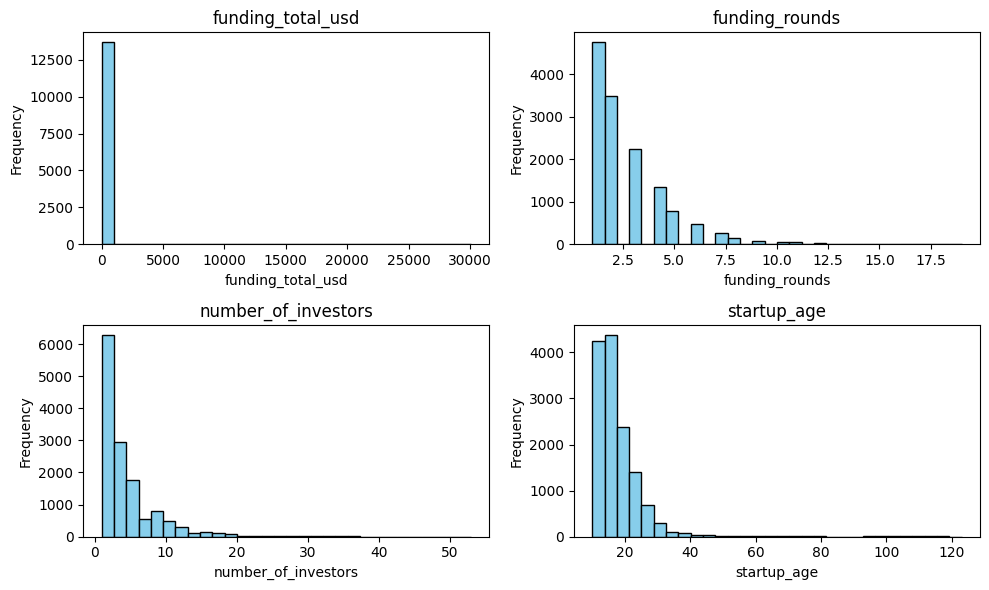

In [20]:
plt.figure(figsize=(10, 6))

for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


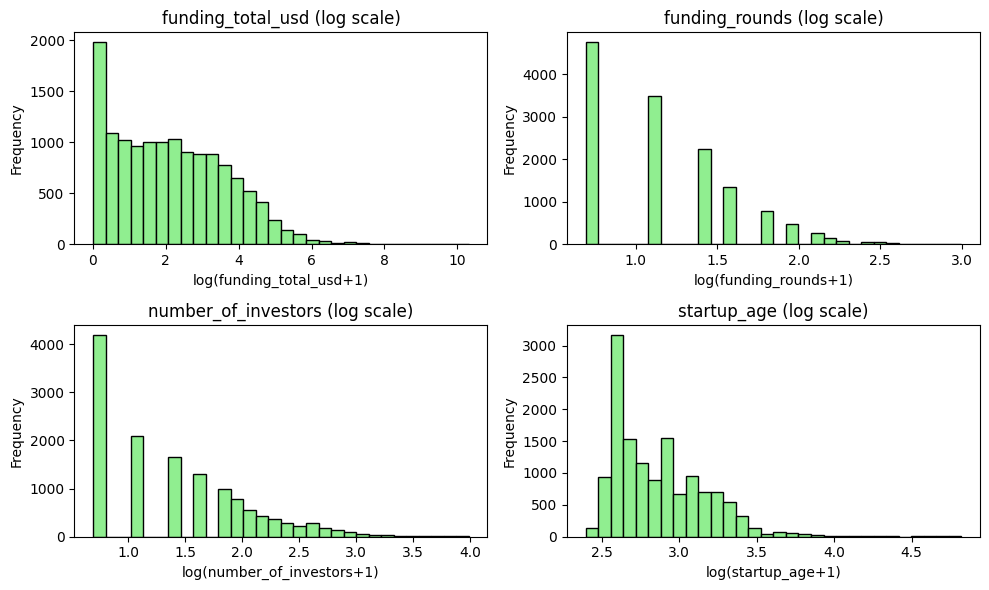

In [21]:
# Applying log transformation to numerical variables to reduce skewness and compress the long-tail.
# This helps to handle extreme outliers and makes distributions more suitable for modeling.

plt.figure(figsize=(10, 6))

for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)
    plt.hist(np.log1p(df[col]), bins=30, color='lightgreen', edgecolor='black')
    plt.title(f'{col} (log scale)')
    plt.xlabel(f'log({col}+1)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [22]:
# Apply log1p transformation to all numerical columns in df

for col in numerical:
    df[col] = np.log1p(df[col])

### **5. Exploratory Data Analysis (EDA)**
----

#### 5.1. Failure Distribution in Dataset

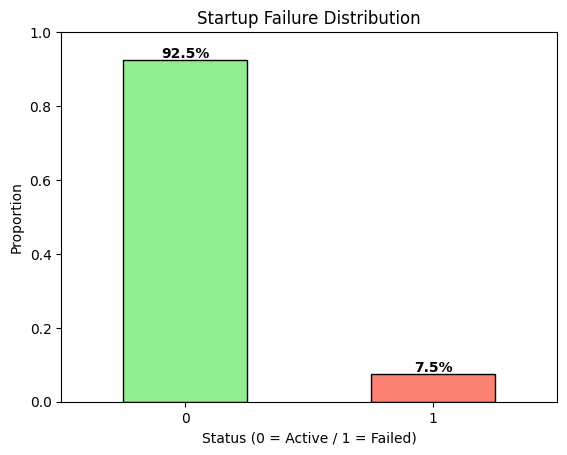

In [23]:
proportions = df['status_binary'].value_counts(normalize=True)

ax = proportions.plot(
    kind='bar',
    color=['lightgreen', 'salmon'],
    edgecolor='black'
)

plt.title('Startup Failure Distribution')
plt.xlabel('Status (0 = Active / 1 = Failed)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

for i, v in enumerate(proportions):
    plt.text(i, v + 0.005, f"{v*100:.1f}%", ha='center', fontweight='bold')

plt.ylim(0, 1)
plt.show()

# Only about 8% of startups are classified as failures, indicating a clear class imbalance that will be addressed during modeling.

#### 5.2. Failure Distribution by Categories

In [24]:
# To start the EDA, we define a minimum sample size to ensure the failure rate can be analyzed meaningfully.
# In statistics, the minimum sample size to estimate a proportion p with confidence level Z and margin of error E is:

# n = (Z^2 * p * (1 - p)) / E^2

Z = 1.96   # 95% confidence
p = 0.08   # expected failure rate (~8%)
E = 0.1    # margin of error 10%

n_min = (Z**2 * p * (1 - p)) / E**2
n_min = math.ceil(n_min)
print(f"Minimum sample size for estimating failure rate with 95% confidence and 10% error: {n_min}")


Minimum sample size for estimating failure rate with 95% confidence and 10% error: 29


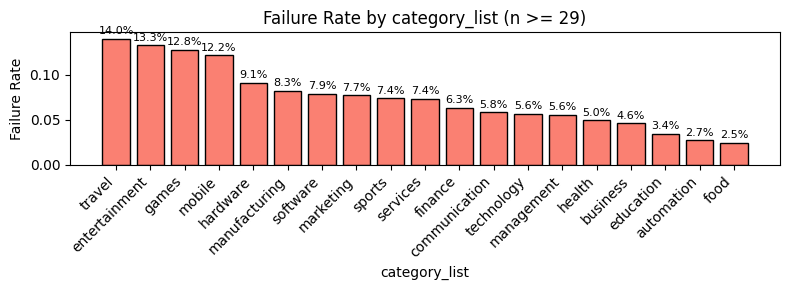

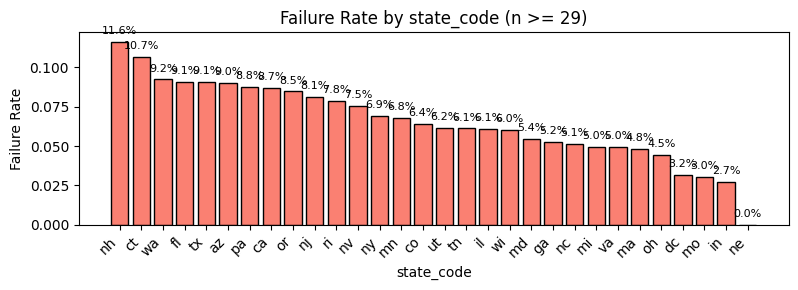

In [25]:
cat_valid = df['category_list'].value_counts()[df['category_list'].value_counts() >= n_min].index
state_valid = df['state_code'].value_counts()[df['state_code'].value_counts() >= n_min].index


for col in categorical:
    df_filtered = df[df[col].isin(cat_valid if col == 'category_list' else state_valid)]
    
    failure_rate = (
        df_filtered.groupby(col)['status_binary']
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    plt.figure(figsize=(8, 3))
    plt.bar(failure_rate[col], failure_rate['status_binary'], color='salmon', edgecolor='black')
    plt.title(f'Failure Rate by {col} (n >= {n_min})')
    plt.xlabel(col)
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    for i, v in enumerate(failure_rate['status_binary']):
        plt.text(i, v + 0.005, f"{v*100:.1f}%", ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Here we can highlight the riskiest groups in these two categories:
# Category_list: travel, entertainment, games, and mobile all have failure rates above 10%, indicating more challenging sectors.
# States: There are no extreme outliers, but NH and CT are slightly above the others in failure rate.

#### 5.3. Failure Distribution in Numerical Features

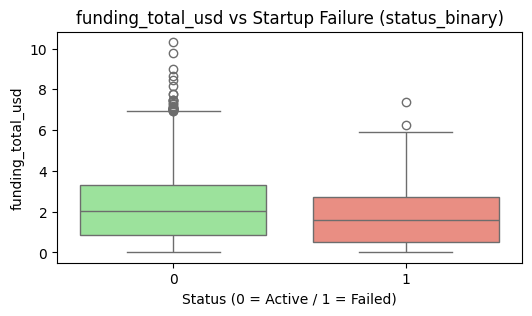

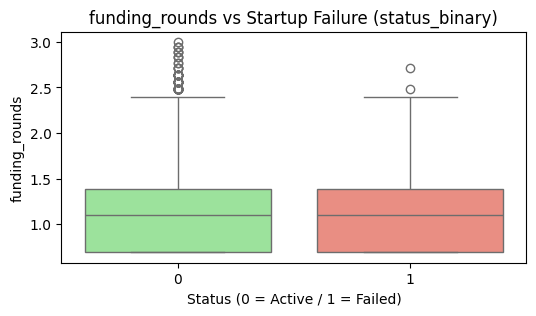

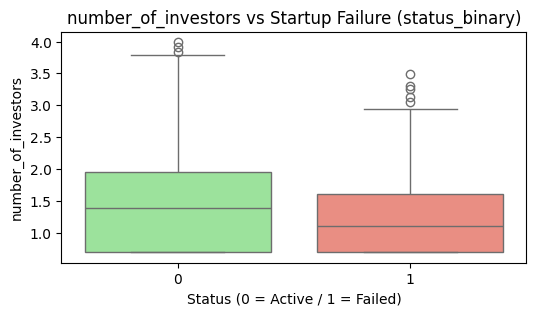

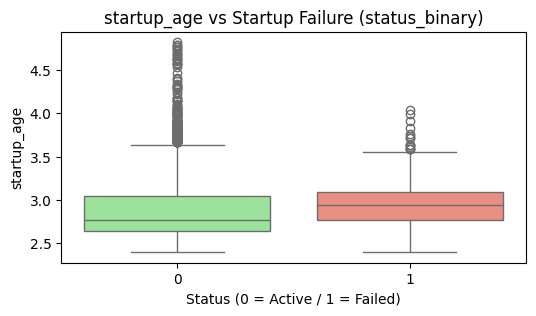

In [26]:
for col in numerical:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='status_binary', y=col, data=df, hue='status_binary', palette=['lightgreen', 'salmon'], dodge=False, legend=False)
    plt.title(f'{col} vs Startup Failure (status_binary)')
    plt.xlabel('Status (0 = Active / 1 = Failed)')
    plt.ylabel(f'{col}')
    plt.show()

# Insights from numerical features:
# - Funding_total_usd: Failed startups tend to have lower funding overall.
# - Funding_rounds: Very similar distribution between failed and active startups, not a strong indicator alone.
# - Number_of_investors: Failed startups generally have fewer investors.
# - Startup_age: Active startups are concentrated among younger ages but have more outliers; 
#                failed startups are slightly older on average but with a more stable distribution.

### **7. Preparing the Dataset**
----

In [34]:
from sklearn.metrics import mutual_info_score

mutual = {}
for i in categorical:
    a = round(mutual_info_score(df['status_binary'],df[i])*100,2)
    mutual[i] = a
df_mutual = pd.DataFrame(list(mutual.items()), columns=['feature', 'mutual_info (%)'])
df_mutual = df_mutual.sort_values(by="mutual_info (%)", ascending=False).reset_index(drop=True)
df_mutual


,feature,mutual_info (%)
0,category_list,0.35
1,state_code,0.30


In [35]:
df[numerical].corrwith(df['status_binary'])

funding_total_usd     -0.072375
funding_rounds        -0.090724
number_of_investors   -0.064769
startup_age            0.076935
dtype: float64

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# Here we need to use the stratify parameter because our dataset is very unbalanced.
# This ensures that the failure ratio (~8%) is preserved in train, validation, and test sets.

df_full_train, df_test = train_test_split(
    df, test_size=0.2, random_state=1, stratify=df['status_binary']
)

df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1, stratify=df_full_train['status_binary']
)

In [29]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_full_train = df_full_train['status_binary'].values
y_train = df_train['status_binary'].values
y_val = df_val['status_binary'].values
y_test = df_test['status_binary'].values

In [31]:
del df_full_train['status_binary']
del df_train['status_binary']
del df_val['status_binary']
del df_test['status_binary']

In [32]:
len(df_full_train), len(df_train), len(df_val), len(df_test)

(10970, 8227, 2743, 2743)